# Movie Lines - Sentiment Analysis

## Read Movie Lines Dataset

In [1]:
import pandas as pd

# Define column names
column_names = ['line_id', 'characterID', 'movieID', 'characterName', 'text']

# Read the file with the provided column names
movie_lines = pd.read_csv('data/movie_lines.tsv', sep='\t', encoding='utf-8', header=None, names=column_names, on_bad_lines='skip')

# Print the first few rows to verify
print(movie_lines.head())

  line_id characterID movieID characterName          text
0   L1045          u0      m0        BIANCA  They do not!
1   L1044          u2      m0       CAMERON   They do to!
2    L985          u0      m0        BIANCA    I hope so.
3    L984          u2      m0       CAMERON     She okay?
4    L925          u0      m0        BIANCA     Let's go.


## Group Movie Lines by Movie ID

To test more informative sentiment analysis, group individual lines by movie.

In [3]:
# Fill missing values with an empty string and ensure conversion to string
movie_lines['text'] = movie_lines['text'].fillna('').astype(str)

# Group and concatenate all the text for each movieID
movie_texts = movie_lines.groupby('movieID')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Print the first few rows to verify
print(movie_texts.head())

  movieID                                               text
0      m0  They do not! They do to! I hope so. She okay? ...
1      m1  Can't be that far I say.  Also I don't like th...
2     m10  All the figures show is that Gordon LaRiviere ...
3    m100  Sending what we know back to U.S.T. via satell...
4    m101  In the backyard. Where? I heard them. Did you ...


# Read Movie Titles to get Genre and merge with Movie Texts

In [5]:
# Define column names for movie_titles_metadata:
metadata_columns = ['movieID', 'title', 'year', 'rating', 'votes', 'genres']

# Load the file with these column names. Adjust if there's already a header in file.
movie_titles_metadata = pd.read_csv('data/movie_titles_metadata.tsv', sep='\t', encoding='utf-8', header=None, names=metadata_columns, on_bad_lines='skip')

# Merge movie_texts and movie_titles_metadata on 'movieID'
merged_df = pd.merge(movie_texts, movie_titles_metadata[['movieID', 'genres']], on='movieID', how='inner')

# Show the first few rows of the merged dataframe
print(merged_df.head())

  movieID                                               text  \
0      m0  They do not! They do to! I hope so. She okay? ...   
1      m1  Can't be that far I say.  Also I don't like th...   
2     m10  All the figures show is that Gordon LaRiviere ...   
3    m100  Sending what we know back to U.S.T. via satell...   
4    m101  In the backyard. Where? I heard them. Did you ...   

                                             genres  
0                              ['comedy' 'romance']  
1       ['adventure' 'biography' 'drama' 'history']  
2                    ['drama' 'mystery' 'thriller']  
3  ['action' 'adventure' 'comedy' 'crime' 'sci-fi']  
4                  ['biography' 'drama' 'thriller']  


## Sentiment Analysis Using BERT

In [7]:
import numpy as np
from transformers import AutoTokenizer
from datasets import Dataset
import re

### Step 1

In [9]:
# Step 1: Extract primary genre from the genres field
def extract_primary_genre(genres_str):
    if pd.isna(genres_str):
        return None
    # Use regex to extract all words (ignoring punctuation)
    genres = re.findall(r"[A-Za-z]+", genres_str)
    if genres:
       return genres[0].lower()
    return None
    
# Apply extraction to create a new column
merged_df['primary_genre'] = merged_df['genres'].apply(extract_primary_genre)

# Check unique genres
unique_genres = merged_df['primary_genre'].unique()
print('Unique genres:', unique_genres)

# Filter genres
filtered_genres = [genre for genre in unique_genres if genre is not None]

# Create a mapping from genre to integer label
genre_to_id = {genre: idx for idx, genre in enumerate(sorted(filtered_genres))}
print('Genre to ID mapping:', genre_to_id)

# Drop rows where primary_genre is None (or )
clean_df = merged_df.dropna(subset=['primary_genre'])
print("Rows after dropping missing genres:", len(clean_df))

# Map genres to labels and cast to integers
clean_df['label'] = clean_df['primary_genre'].map(genre_to_id).astype(int)

Unique genres: ['comedy' 'adventure' 'drama' 'action' 'biography' 'crime' 'mystery'
 'fantasy' None 'animation' 'short' 'family' 'horror' 'thriller' 'sci'
 'romance' 'documentary' 'film']
Genre to ID mapping: {'action': 0, 'adventure': 1, 'animation': 2, 'biography': 3, 'comedy': 4, 'crime': 5, 'documentary': 6, 'drama': 7, 'family': 8, 'fantasy': 9, 'film': 10, 'horror': 11, 'mystery': 12, 'romance': 13, 'sci': 14, 'short': 15, 'thriller': 16}
Rows after dropping missing genres: 605


C:\Users\tterr\AppData\Local\Temp\ipykernel_28948\592367546.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label'] = clean_df['primary_genre'].map(genre_to_id).astype(int)


### Step 2

In [11]:
# Step 2: Convert merged_df to Hugging Face Dataset (only keep 'text' and 'label')
hf_dataset = Dataset.from_pandas(clean_df[['text', 'label']])
print("Hugging Face dataset created with cleaned data.")

Hugging Face dataset created with cleaned data.


### Step 3

In [13]:
# Step 3: Tokenize the text column using BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

# Tokenize the dataset
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
print('Dataset tokenization complete')

Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Dataset tokenization complete


### Step 4

In [15]:
# Step 4: Split the dataset into training and validation sets (80-20 split)
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(eval_dataset))

Training dataset size: 484
Validation dataset size: 121


### Step 5

In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Determine number of labels from the mapping (exclude None since it's not used)
num_labels = len(genre_to_id)

# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
print("BERT model loaded for classification with", num_labels, "labels.")

# Define training arguments for the Trainer
training_args = TrainingArguments(
    output_dir="./results",            # output directory for model predictions and checkpoints
    num_train_epochs=3,                # total number of training epochs
    per_device_train_batch_size=8,     # batch size per device during training
    per_device_eval_batch_size=8,      # batch size for evaluation
    evaluation_strategy="epoch",       # evaluation strategy to adopt during training
    save_strategy="epoch",             # save model every epoch
    logging_dir="./logs",              # directory for storing logs
    load_best_model_at_end=True,       # load the best model at the end of training
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer used for encoding the data
)

print("Trainer set up successfully.")

# Start training the model
trainer.train()
print("Training completed!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tterr\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tterr\AppData\Local\Temp\ipykernel_28948\108676329.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


BERT model loaded for classification with 17 labels.
Trainer set up successfully.


Epoch,Training Loss,Validation Loss
1,2.074600,2.092741
2,2.047600,1.967366
3,1.946300,1.932575


Training completed!


# Evaluation Results

In [19]:
# 1. Evaluate the model on the validation set
eval_results = trainer.evaluate(eval_dataset)
print("Evaluation Results:")
print(eval_results)

Evaluation Results:
{'eval_loss': 1.93257474899292, 'eval_runtime': 1.1197, 'eval_samples_per_second': 108.068, 'eval_steps_per_second': 14.29, 'epoch': 3.0}


In [21]:
# 2. Run predictions on the evaluation set (or a subset) to inspect model predictions
predictions_output = trainer.predict(eval_dataset)

# The predictions are raw logits; convert them to predicted labels by taking argmax over logits.
predicted_labels = np.argmax(predictions_output.predictions, axis=1)

print("Sample predicted labels:", predicted_labels[:10])
print("True labels for first 10 examples:", eval_dataset['label'][:10])

Sample predicted labels: [0 0 7 4 4 7 4 0 4 7]
True labels for first 10 examples: [5, 11, 7, 7, 4, 7, 7, 0, 4, 7]


## Visualize Results

Confusion Matrix:
 [[25  0  0  0  4  0  0  5  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  4  0  0  0  0  0]
 [ 2  0  0  0 13  0  0  6  0  0  0  0  0]
 [ 5  0  0  0  3  0  0  5  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  8  0  0  8  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 5  0  0  0  2  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]]


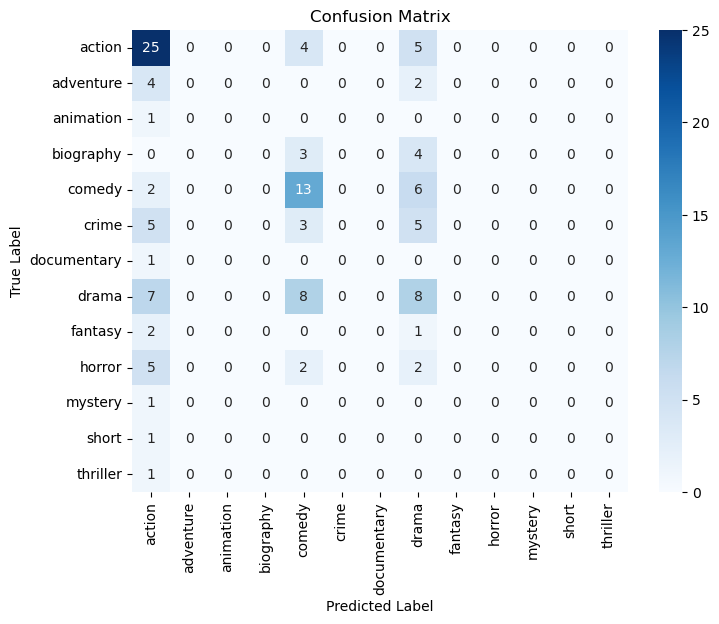

Classification Report:
              precision    recall  f1-score   support

      action       0.45      0.74      0.56        34
   adventure       0.00      0.00      0.00         6
   animation       0.00      0.00      0.00         1
   biography       0.00      0.00      0.00         7
      comedy       0.39      0.62      0.48        21
       crime       0.00      0.00      0.00        13
 documentary       0.00      0.00      0.00         1
       drama       0.24      0.35      0.29        23
     fantasy       0.00      0.00      0.00         3
      horror       0.00      0.00      0.00         9
     mystery       0.00      0.00      0.00         1
       short       0.00      0.00      0.00         1
    thriller       0.00      0.00      0.00         1

    accuracy                           0.38       121
   macro avg       0.08      0.13      0.10       121
weighted avg       0.24      0.38      0.30       121



C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels from the evaluation dataset
true_labels = np.array(eval_dataset['label'])

# Get raw predictions and convert to predicted labels
predictions_output = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions_output.predictions, axis=1)

# Create a reverse mapping from label id to genre
id_to_genre = {v: k for k, v in genre_to_id.items()}

# Get the unique labels present in the eval set (sorted by label id)
unique_ids = sorted(np.unique(true_labels))
target_names = [id_to_genre[i] for i in unique_ids]

# Compute the confusion matrix specifying only the labels present in eval
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_ids)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate and print a classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, labels=unique_ids, target_names=target_names))